### Preparing the dataset 

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.
But in contrast to homework #2 we are going to use all columns of the dataset.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Fill missing values with zeros.
* Apply the log tranform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data.csv')
df = df[(df['ocean_proximity'] == '<1H OCEAN') | (df['ocean_proximity'] == 'INLAND')]
df.reset_index(inplace=True, drop=True)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN
1,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN
2,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN
3,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN
4,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN


In [3]:
# fill missing values with zeros
df = df.fillna(0)

# split data
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

# reset index
df_train_full.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

# apply log transformation
y_train = np.log1p(df_train['median_house_value'].values)
y_val = np.log1p(df_val['median_house_value'].values)
y_test = np.log1p(df_test['median_house_value'].values)

# drop target variable from train data
df_train_full.drop(columns=['median_house_value'], inplace=True)
df_train.drop(columns=['median_house_value'], inplace=True)
df_val.drop(columns=['median_house_value'], inplace=True)
df_test.drop(columns=['median_house_value'], inplace=True)


In [4]:
df_val.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.74,38.48,12.0,4174.0,670.0,1882.0,647.0,4.5510,<1H OCEAN
1,-121.67,36.93,22.0,569.0,132.0,542.0,125.0,2.1875,<1H OCEAN
2,-120.90,39.95,20.0,1349.0,238.0,601.0,203.0,3.5417,INLAND
3,-118.14,34.02,44.0,1715.0,460.0,1740.0,423.0,2.7019,<1H OCEAN
4,-118.11,33.80,36.0,1837.0,319.0,810.0,305.0,4.3897,<1H OCEAN


In [5]:
# OHE and change dataframe to matrices
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=True)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* **`ocean_proximity`**
* `total_rooms`
* `latitude`
* `population`

In [6]:
from sklearn.tree import DecisionTreeRegressor, export_text

In [7]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [8]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* **0.245**
* 0.545
* 0.845

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [10]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [11]:
y_pred = rf.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

0.24518772479229903

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

- 10
- 25
- 50
- **160**

In [12]:
estimator_scores = []
for estimators in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=estimators, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    estimator_scores.append((estimators, rmse))

In [13]:
df_est_scores = pd.DataFrame(estimator_scores, columns=['n_estimators', 'score'])
df_est_scores.head()

,n_estimators,score
0,10,0.245188
1,20,0.238674
2,30,0.236887
3,40,0.235265
4,50,0.234869


In [14]:
import matplotlib.pyplot as plt

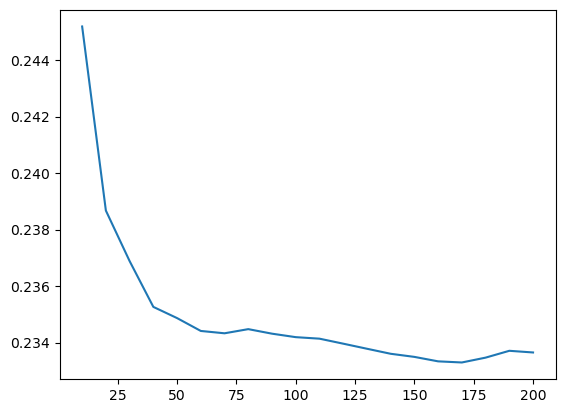

In [15]:
plt.plot(df_est_scores['n_estimators'], df_est_scores['score'])

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* **25**

In [16]:
depth_scores = []

for depth in [10, 15, 20, 25]:
    total_estimator_score = 0
    for estimators in range(10, 201, 10):
        rf = RandomForestRegressor(max_depth=depth, n_estimators=estimators, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        total_estimator_score += rmse
    depth_scores.append((depth, total_estimator_score/20))

In [17]:
df_depth_scores = pd.DataFrame(depth_scores, columns=['max_depth', 'score'])
df_depth_scores.head()

,max_depth,score
0,10,0.245455
1,15,0.235921
2,20,0.235151
3,25,0.234826


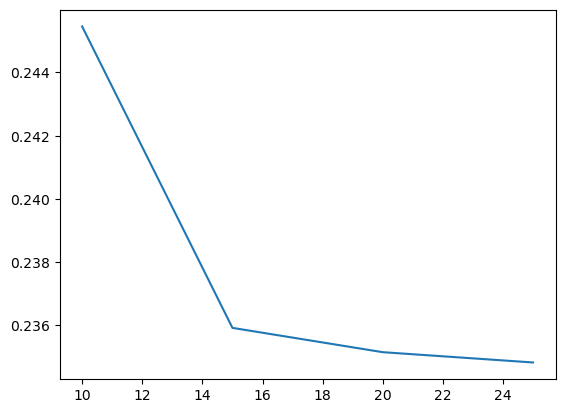

In [18]:
plt.plot(df_depth_scores['max_depth'], df_depth_scores['score'])

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `total_rooms`
* **`median_income`**
* `total_bedrooms`
* `longitude`

In [19]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [20]:
df_feat_imp = pd.DataFrame(zip(dv.get_feature_names_out(), rf.feature_importances_), columns=['Feature', 'Importance'])
df_feat_imp.head()

,Feature,Importance
0,households,0.015021
1,housing_median_age,0.030305
2,latitude,0.101956
3,longitude,0.086276
4,median_income,0.335592


<BarContainer object of 10 artists>

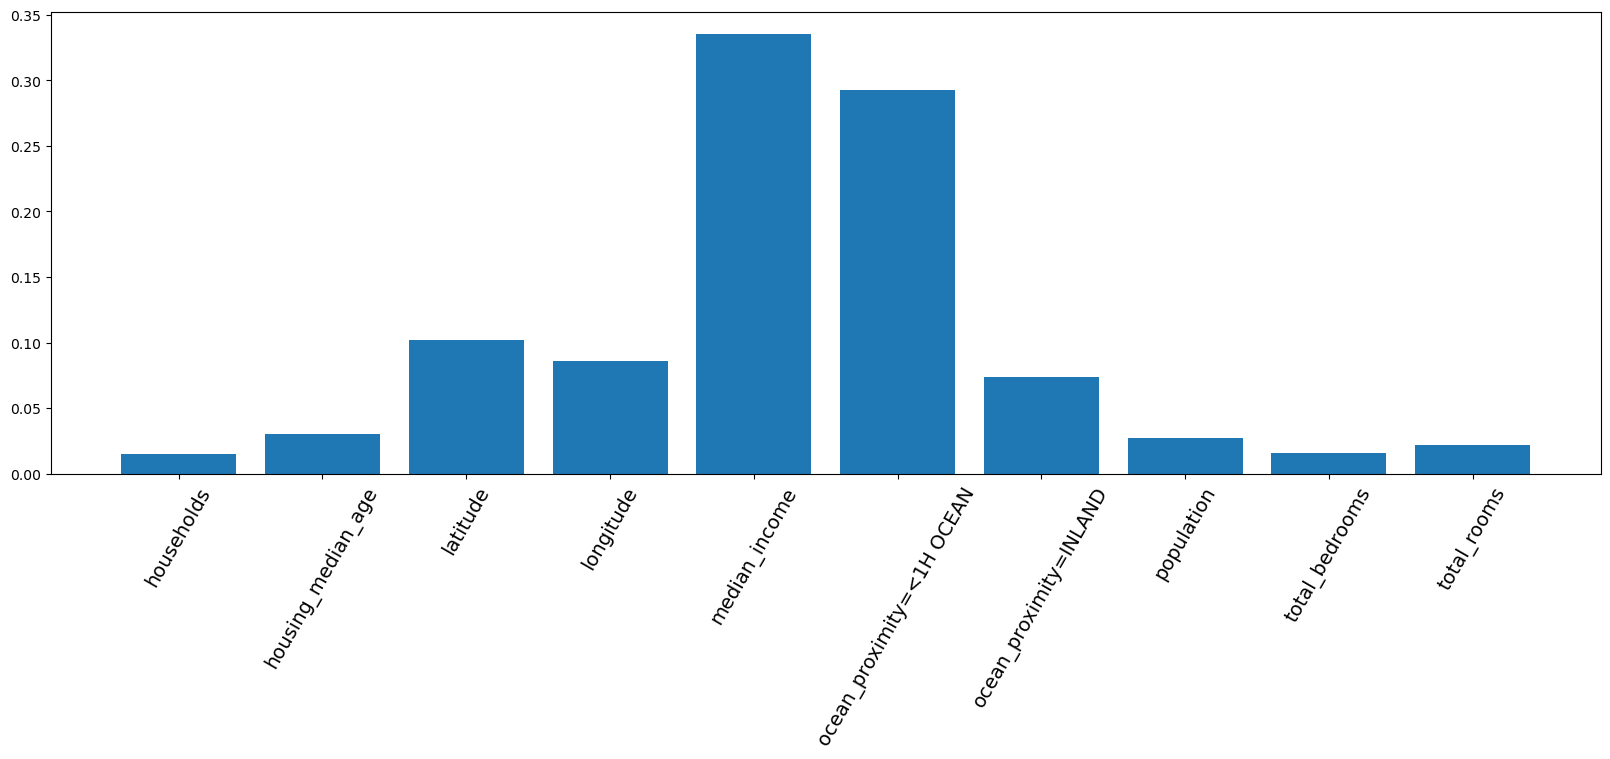

In [21]:
plt.figure(figsize=(20,6))
plt.xticks(rotation=60, fontsize=14)
plt.bar(df_feat_imp['Feature'], df_feat_imp['Importance'])

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* **0.1**
* Both give equal value

In [22]:
import xgboost as xgb

In [23]:
# get feature names and remove '<', '='
features = dv.get_feature_names_out()
features = [f.replace('<', '_') for f in features]
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=_1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [24]:
# create DMatrices
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [25]:
def parse_xgb_output_to_df(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [26]:
%%capture output

# create watchlist and model
watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [27]:
df_eta1 = parse_xgb_output_to_df(output)

In [28]:
%%capture output
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [29]:
df_eta3 = parse_xgb_output_to_df(output)

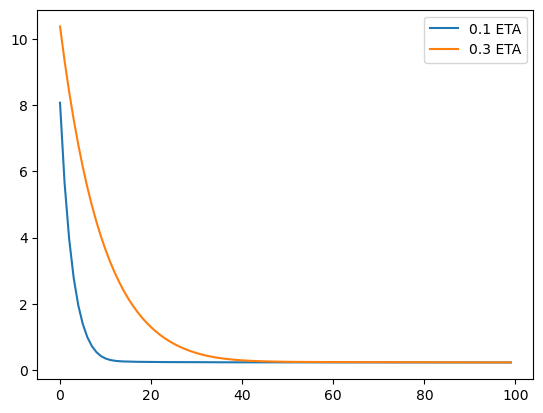

In [30]:
plt.plot(df_eta1['num_iter'], df_eta1['val_rmse'], label='0.1 ETA')
plt.plot(df_eta3['num_iter'], df_eta3['val_rmse'], label='0.3 ETA')
plt.legend()

In [31]:
print("RMSE with ETA=0.1:", round(df_eta1['val_rmse'].iloc[-1], 3))

RMSE with ETA=0.1: 0.229


In [32]:
print("RMSE with ETA=0.3:", round(df_eta3['val_rmse'].iloc[-1], 3))

RMSE with ETA=0.3: 0.232
